[colab link](https://colab.research.google.com/drive/1tHMTSL8H0ZIfc_kMOMYyWSpajFi0S-PA?usp=sharing)

# Backgorund
Everyone in the middle east neighborhood knows quite is only temporary in the
Israel-Gaza relationship. Since Hamas’s, the organization currently in control in Gaza, strategy in warfare is that civilians are a legitimate target in the stratigic struggle. Israeli citizens have become a custom to missile threats, which range in relevance depending on the range of a property from Gaza. In this project we perform a case study analysis of the relation between closeness to Gaza, and realestate price.


# Research Question
What is the relation between a property's distance from Gaza and it's realestate price? 

# Get the Data
For reproducability all of the extracted data is can be seen at this [Kaggle dataset](https://www.kaggle.com/amirbialer/Israel-RealEstate) which I conducted.

In [ ]:
import json
import os

!mkdir /root/.kaggle/
!pip install kaggle 

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir ./datasets
!mkdir ./datasets/realestate

!kaggle datasets download -d amirbialer/israel-realestate -p ./datasets/realestate
!unzip ./datasets/realestate/*.zip  -d ./datasets/realestate/

  0% 0.00/854k [00:00<?, ?B/s]
100% 854k/854k [00:00<00:00, 54.0MB/s]
Archive:  ./datasets/realestate/israel-realestate.zip
  inflating: ./datasets/realestate/CITY.xml  
  inflating: ./datasets/realestate/Nadlan_Loaded.JPG  
  inflating: ./datasets/realestate/Nadlan_Loading.JPG  
  inflating: ./datasets/realestate/all.pkl  
  inflating: ./datasets/realestate/cities_file.pkl  
  inflating: ./datasets/realestate/city_parsed_table.csv  


## Get city list
- I got the list from data gov: https://data.gov.il/dataset/828
- I couldn't understand the coordinates unites so I scraped new ones with `nominatim` python package.
- for later use- I encode the city name in percent encoding.

In [ ]:
!pip install geopandas
!pip install descartes
!pip install geopy
!pip install folium
!pip install imageio

In [ ]:
import folium
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import urllib.parse
from functools import lru_cache
from scipy.interpolate import interp1d # for transfering font size
import time
from geopy.geocoders import Nominatim
import pickle
from tqdm import tqdm
tqdm.pandas()
geolocator = Nominatim(user_agent="Data Science Education App") #  Using OpenStreetMap Nominatim
import geopandas
from google.colab import drive
drive._mount('/content/drive')

In [ ]:
with open('/content/datasets/realestate/CITY.xml', 'r') as f:
    data = f.read() 


In [ ]:
city_list=data.split("esri:Record")[2:]
len(city_list)

1240

In [ ]:
def parse_cities(i):
  try:
    city_string=re.search("string'>(.*?)(?=<)",i)[0]
    city_name=re.search("(?<=string'>)(.*?)(?=<)",i)[0]
    city_type=re.search("(?<=string'>)(.*?)(?=<)",i.replace(city_string,""))[0]
    url_name=urllib.parse.quote_plus(city_name).replace("+","%20")
    return {"name":city_name,"city_type":city_type, "url_name":url_name}
  except:
    return {"name":np.nan,"city_type":np.nan, "url_name":np.nan}

In [ ]:
parsed_cities=pd.DataFrame.from_records(pd.Series(city_list).apply(parse_cities))
parsed_cities

name  ...                                           url_name
0      גני יוחנן  ...  %D7%92%D7%A0%D7%99%20%D7%99%D7%95%D7%97%D7%A0%...
1         גינתון  ...               %D7%92%D7%99%D7%A0%D7%AA%D7%95%D7%9F
2           בקוע  ...                           %D7%91%D7%A7%D7%95%D7%A2
3        שיבולים  ...         %D7%A9%D7%99%D7%91%D7%95%D7%9C%D7%99%D7%9D
4          יטבתה  ...                     %D7%99%D7%98%D7%91%D7%AA%D7%94
...          ...  ...                                                ...
1235     בית שמש  ...            %D7%91%D7%99%D7%AA%20%D7%A9%D7%9E%D7%A9
1236  קריית אונו  ...  %D7%A7%D7%A8%D7%99%D7%99%D7%AA%20%D7%90%D7%95%...
1237    קריית גת  ...      %D7%A7%D7%A8%D7%99%D7%99%D7%AA%20%D7%92%D7%AA
1238    ראש העין  ...      %D7%A8%D7%90%D7%A9%20%D7%94%D7%A2%D7%99%D7%9F
1239   רמת השרון  ...  %D7%A8%D7%9E%D7%AA%20%D7%94%D7%A9%D7%A8%D7%95%...

[1240 rows x 3 columns]

In [ ]:
@lru_cache(maxsize=256)
def get_location(loc):
  try:
    time.sleep(0.3)
    place= geolocator.geocode(loc)
    return place
  except:
    return np.nan

In [ ]:
def get_xy(sf):
  try:
    lat=float(re.findall("(?<=\()(.*)(?=\,)",sf[i]["Point"])[0])
    long=float(re.findall("(?<=\,)(.*)(?=\))",sf[i]["Point"])[0])
    return (lat,long)
  except:
    return (np.nan,np.nan)

In [ ]:
parsed_cities["loc"]=parsed_cities["name"].progress_apply(get_location)

In [ ]:
non_np=parsed_cities.dropna()

In [ ]:
non_np["latitude"]=non_np["loc"].apply(lambda x: x.latitude)
non_np["longitude"]=non_np["loc"].apply(lambda x: x.longitude)
non_np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


name                         city_type  ...   latitude  longitude
0      גני יוחנן       מושבים (כפרים שיתופיים) (ב)  ...  31.860290  34.840736
1         גינתון       מושבים (כפרים שיתופיים) (ב)  ...  31.963029  34.915007
2           בקוע       מושבים (כפרים שיתופיים) (ב)  ...  31.829428  34.927040
3        שיבולים       מושבים (כפרים שיתופיים) (ב)  ...  31.395980  34.608935
4          יטבתה                           קיבוצים  ...  29.895920  35.059622
...          ...                               ...  ...        ...        ...
1235     בית שמש  50000-99999 תושבים,ישובים יהודים  ...  31.746214  34.988683
1236  קריית אונו  20000-49999 תושבים,ישובים יהודים  ...  32.059169  34.859430
1237    קריית גת  20000-49999 תושבים,ישובים יהודים  ...  31.603149  34.777927
1238    ראש העין  20000-49999 תושבים,ישובים יהודים  ...  32.094624  34.961087
1239   רמת השרון  20000-49999 תושבים,ישובים יהודים  ...  32.143128  34.838085

[1096 rows x 6 columns]

In [ ]:
gdf = geopandas.GeoDataFrame(
    non_np, geometry=geopandas.points_from_xy(non_np.latitude, non_np.longitude))

In [ ]:
gdf

name  ...                   geometry
0      גני יוחנן  ...  POINT (31.86029 34.84074)
1         גינתון  ...  POINT (31.96303 34.91501)
2           בקוע  ...  POINT (31.82943 34.92704)
3        שיבולים  ...  POINT (31.39598 34.60893)
4          יטבתה  ...  POINT (29.89592 35.05962)
...          ...  ...                        ...
1235     בית שמש  ...  POINT (31.74621 34.98868)
1236  קריית אונו  ...  POINT (32.05917 34.85943)
1237    קריית גת  ...  POINT (31.60315 34.77793)
1238    ראש העין  ...  POINT (32.09462 34.96109)
1239   רמת השרון  ...  POINT (32.14313 34.83809)

[1096 rows x 7 columns]

In [ ]:
gdf.loc[gdf["name"]=="באר שבע"]

name  ...                   geometry
1018  באר שבע  ...  POINT (31.24574 34.79252)

[1 rows x 7 columns]

In [ ]:
m=folium.Map(location=(31.2457442,34.7925181), zoom_start=8)
for i in range(len(gdf)):
#  try:
  lat=gdf.iloc[i]["latitude"]
  long=gdf.iloc[i]["longitude"]
  folium.Marker(
  location=[lat,long] ,# coordinates for the marker (Earth Lab at CU Boulder)
  popup=gdf.iloc[i]['name'], # pop-up label for the marker
  icon=folium.Icon()
      ).add_to(m)
#  except:
#    print(i)
m

<font size="5"> Lots of cities!</font>

because scraping each city takes time,<br>
I limit the analysis south of *Rishon Le Zion* and north of *Mizpe Ramon*

In [ ]:
high_bound=gdf.loc[gdf["name"]=="ראשון לציון","latitude"].values[0]
low_bound=gdf.loc[gdf["name"]=="מצפה רמון","latitude"].values[0]
final_cities=gdf.loc[np.logical_and(gdf["latitude"]>=low_bound,gdf["latitude"]<=high_bound)]
final_cities

name  ...                   geometry
0     גני יוחנן  ...  POINT (31.86029 34.84074)
1        גינתון  ...  POINT (31.96303 34.91501)
2          בקוע  ...  POINT (31.82943 34.92704)
3       שיבולים  ...  POINT (31.39598 34.60893)
9         שלווה  ...  POINT (31.56352 34.76804)
...         ...  ...                        ...
1227     דימונה  ...  POINT (31.06866 35.03665)
1231   באר יעקב  ...  POINT (31.94435 34.83986)
1232       גדרה  ...  POINT (31.81177 34.78039)
1235    בית שמש  ...  POINT (31.74621 34.98868)
1237   קריית גת  ...  POINT (31.60315 34.77793)

[375 rows x 7 columns]

In [ ]:
m=folium.Map(location=(31.2457442,34.7925181), zoom_start=8)
for i in range(len(final_cities)):
#  try:
  lat=final_cities.iloc[i]["latitude"]
  long=final_cities.iloc[i]["longitude"]
  folium.Marker(
  location=[lat,long] ,# coordinates for the marker (Earth Lab at CU Boulder)
  popup=final_cities.iloc[i]['name'], # pop-up label for the marker
  icon=folium.Icon()
      ).add_to(m)
#  except:
#    print(i)
m

## Scrape Real Estate Deals
I contacted many Israely goverment agencies asking for access for the data and was either refused or didn't get any answer.

So we are scraping the data ourselves from [nadlan.gov.il](nadlan.gov.il)

Since this is a **dynamic website** which only loads when scrolling to the bottom of the screen- I need to use selenium webdriver and to wait about 5 minutes to extract ~ 1000 samples for each city.

### Example of a loading website

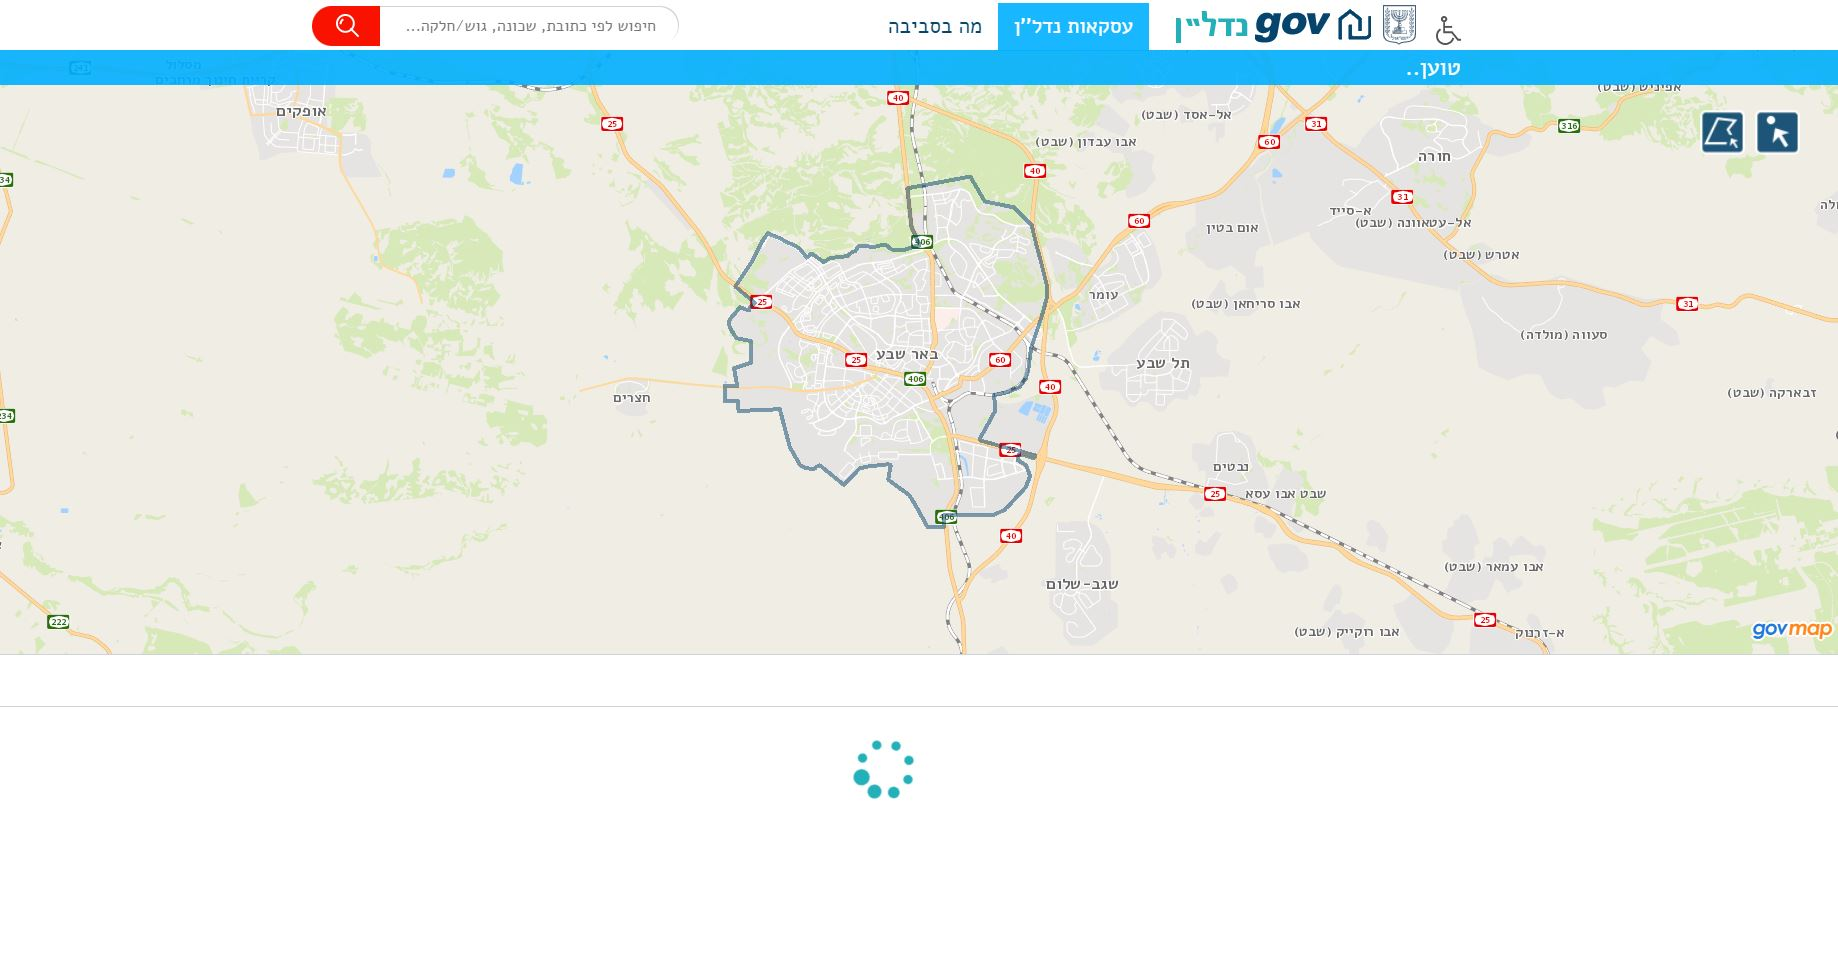

In [ ]:
from IPython.display import Image
Image('/content/datasets/realestate/Nadlan_Loading.JPG', width=1200)

### Example of a loaded website

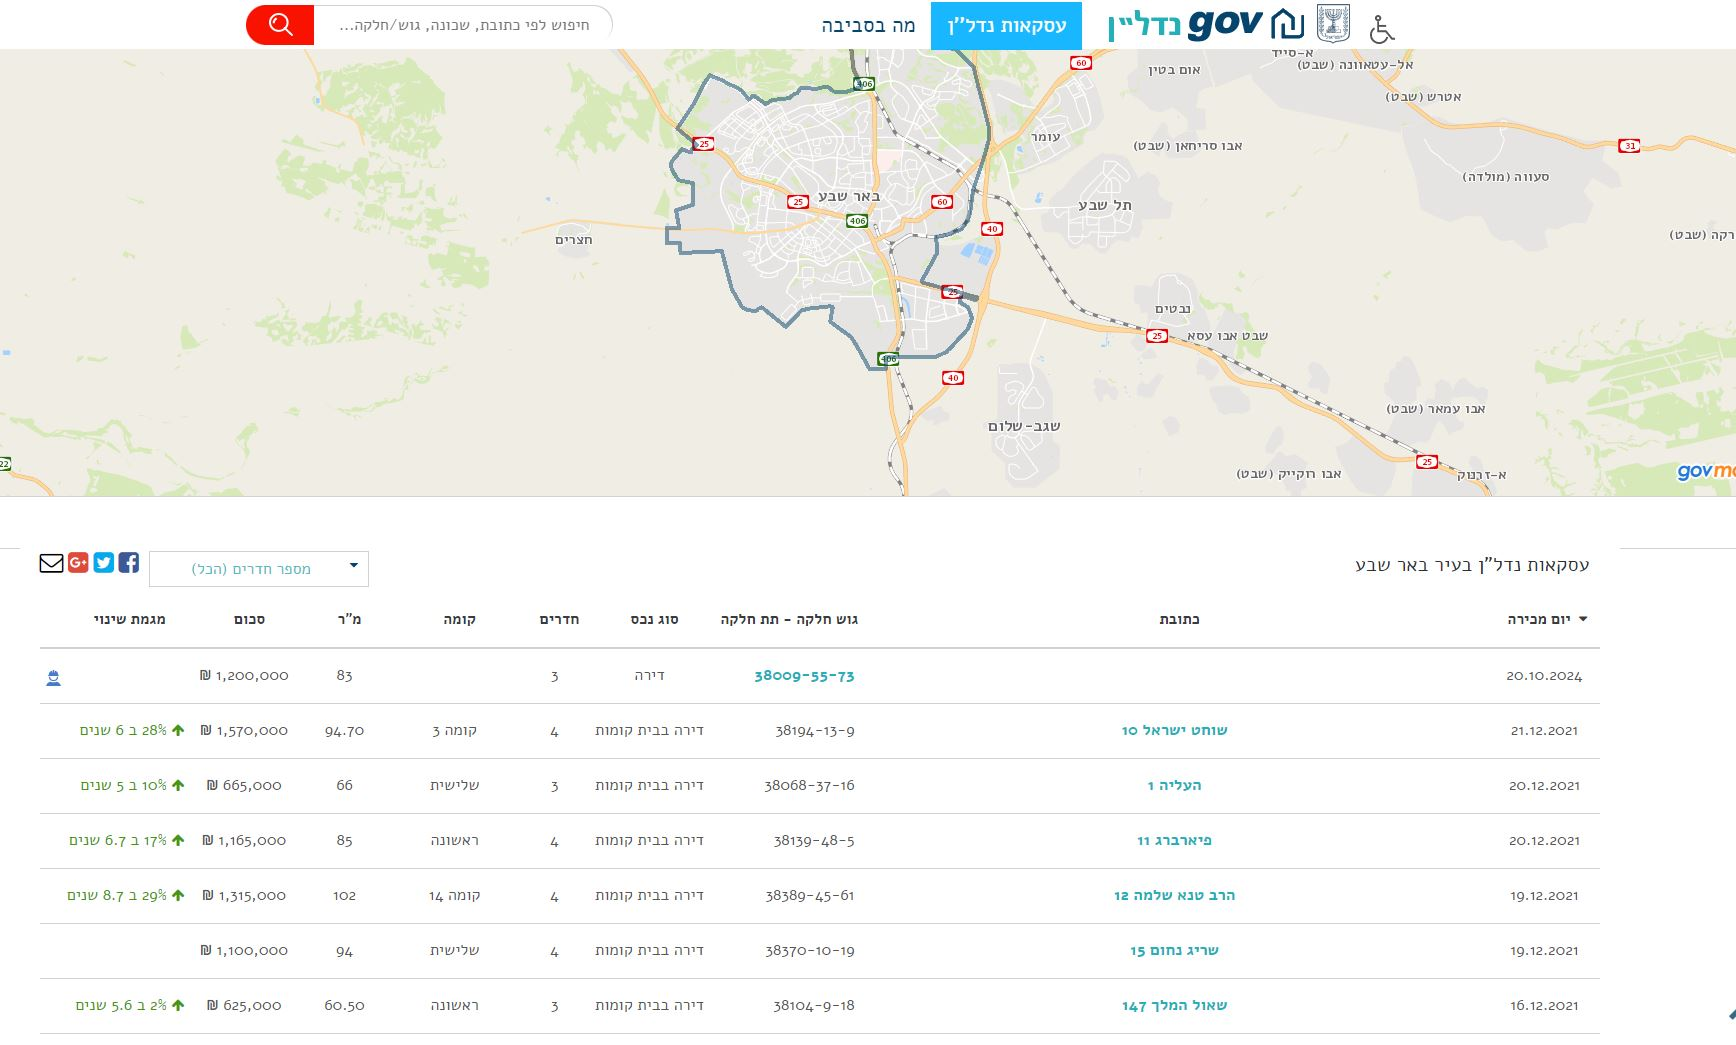

In [ ]:
from IPython.display import Image
Image('/content/datasets/realestate/Nadlan_Loaded.JPG', width=1200)

In [ ]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
# set options to be headless
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)

In [ ]:
from selenium import webdriver
import time

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)

In [ ]:
example_url = "https://www.nadlan.gov.il/?search=%D7%91%D7%90%D7%A8%20%D7%A9%D7%91%D7%A2"
nadlan_url="https://www.nadlan.gov.il/?search="


In [ ]:
final_cities=pickle.load(open("/content/datasets/realestate/cities_file.pkl","rb"))

In [ ]:
def scrape_city(city_url, max_iterations=300):
  if isinstance(city_url,list): city_url=city_url.values[0]
  a_list=[0]
  try:
    url=nadlan_url+city_url
    SCROLL_PAUSE_TIME = 2
    driver = webdriver.Chrome('chromedriver',options=options)
    driver.maximize_window()
    driver.get(url)
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    for i in tqdm(range(max_iterations)):    # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        a=driver.page_source
        a_list.append(a)
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        last_height = new_height
        if i>10 and len(a_list[-1].split("dealDetails"))==len(a_list[-10].split("dealDetails")):
          print("stop!")
          break
    return a_list[-1]
  except:
    return a_list[-1]


In [ ]:
final_cities.loc[final_cities["name"]=="באר שבע"]["url_name"]

1018    %D7%91%D7%90%D7%A8%20%D7%A9%D7%91%D7%A2
Name: url_name, dtype: object

In [ ]:
raw_nadlan_data=scrape_city(final_cities.loc[final_cities["name"]=="באר שבע"]["url_name"])
raw_nadlan_data

100%|██████████| 300/300 [11:07<00:00,  2.23s/it]


'<html lang="en"><head><style type="text/css">@charset "UTF-8";[ng\\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\\:form{display:block;}</style>\n    <meta http-equiv="Content-type" content="text/html; charset=utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0,user-scalable=no">\n    \n    <title ng-bind="MetaTitle"> אתר הנדל\'\'ן הממשלתי - באר שבע</title>\n    <link rel="shortcut icon" href="./images/logo_shekel.png">\n\n    <meta name="description" content=" אתר הנדל\'\'ן הממשלתי - באר שבע">\n    <meta name="keywords" content=" אתר הנדל\'\'ן הממשלתי - באר שבע">\n    <meta name="application-name" content=" אתר הנדל\'\'ן הממשלתי - באר שבע">\n    <meta name="apple-mobile-web-app-title" content=" אתר הנדל\'\'ן הממשלתי - באר שבע">\n    <meta property="og:title" content=" אתר הנדל\'\'ן הממשלתי - באר שבע">\n    <meta pro

In [ ]:
l=raw_nadlan_data.split("dealDetails")#[1:-1]
print("number of real estate deals: {}".format(len(l)))

number of real estate deals: 961


### Parsing

In [ ]:
i=l[4] #example of a row
i


'">\n\n            <!-- ngIf: data[\'DEALDATE\'] --><div class="dealRow" ng-if="data[\'DEALDATE\']">\n                תאריך העסקה :  02.11.2021\n            </div><!-- end ngIf: data[\'DEALDATE\'] -->\n            <!-- ngIf: data[\'ASSETROOMNUM\'] --><div class="dealRow" ng-if="data[\'ASSETROOMNUM\']">\n                מספר חדרים : 4\n            </div><!-- end ngIf: data[\'ASSETROOMNUM\'] -->\n            <!-- ngIf: data[\'FLOORNO\'] --><div class="dealRow" ng-if="data[\'FLOORNO\']">\n                קומה : שמינית\n            </div><!-- end ngIf: data[\'FLOORNO\'] -->\n            <!-- ngIf: data[\'DEALNATURE\'] --><div class="dealRow" ng-if="data[\'DEALNATURE\']">\n                שטח : 79.80 מ"ר\n            </div><!-- end ngIf: data[\'DEALNATURE\'] -->\n            <!-- ngIf: data[\'TREND_FORMAT\'] && data[\'NEWPROJECTTEXT\'] != \'1\' --><div class="dealRow" ng-if="data[\'TREND_FORMAT\'] &amp;&amp; data[\'NEWPROJECTTEXT\'] != \'1\' ">\n                <b>מגמת שינוי :</b>\n        

In [ ]:
def parse_deal(i):
  try:
    change_text=re.findall(r"</i>(.*?)</span.",i.replace("\n",""))[0]
    change_text.replace(" ","")
    change_time_text=re.findall("ב(.*?)שנים",change_text)[0]
    change_time=float(change_time_text)
    per_text=change_text.replace(change_time_text,"")
    re.findall("(.*?)שנים",per_text.replace("%",""))
    num=float(re.findall("\d{1,3}",per_text.replace("%",""))[0])
    is_neg=re.findall("-",per_text)
    if is_neg: num*=-1
  except:
    num=np.nan
    change_time=np.nan


  try:
    d=re.findall(r"[\d]{1,2}.[\d]{1,2}.[\d]{4}", i)[0]
    rooms_text=re.findall(r"מספר חדרים : [\d]{1,2}", i)[0]
    rooms=re.findall(r"[\d]{1,2}",rooms_text)[0]
    area_text=re.findall(r"שטח : [\d]{1,2}", i)[0]
    area=re.findall(r"[\d]{1,2}",area_text)[0]
    price_text=re.findall(r"נמכר ב- [\d]{6,7}", i.replace(",",""))[0]
    price=re.findall(r"[\d]{6,7}",price_text)[0]
    return {"date":d, "rooms":rooms, "area":area, "price":price, "change":num, "change_time":change_time}
  except:
    return {"date":np.nan, "rooms":np.nan, "area":np.nan, "price":np.nan,"change":np.nan, "change_time":np.nan}



In [ ]:
parse_deal(i)

{'area': '79',
 'change': 15.0,
 'change_time': 5.3,
 'date': '02.11.2021',
 'price': '823000',
 'rooms': '4'}

In [ ]:
def parse_all(all):
  all_list=pd.Series(all.split("dealDetails")[1:-1])
  if len(all_list)>0:
    parsed=pd.DataFrame.from_records(all_list.apply(parse_deal)).dropna(subset=["price"])
    return parsed
  return pd.DataFrame(columns=["date", "rooms", "area", "price","change", "change_time"])

  

In [ ]:
parsed=parse_all(raw_nadlan_data)
parsed#missing

date rooms area    price  change  change_time
0    20.10.2024     3   83  1200000     NaN          NaN
1    02.11.2021     4   84   850000     9.0          3.2
2    02.11.2021     4   86  1160000    12.0          5.9
3    02.11.2021     4   79   823000    15.0          5.3
4    02.11.2021     4   79   895000    31.0          7.5
..          ...   ...  ...      ...     ...          ...
954  25.07.2021     5   13  1530000     NaN          NaN
955  25.07.2021     3   62   565000     NaN          NaN
956  25.07.2021     5   14  1550000     NaN          NaN
957  25.07.2021     4   89  1200000     NaN          NaN
958  25.07.2021     5   12  1500000     NaN          NaN

[949 rows x 6 columns]

### Scraping process
took about ~72 hours

In [ ]:
import pickle
import geopandas 

In [ ]:
gdf=pickle.load(open("/content/datasets/realestate/cities_file.pkl","rb"))

In [ ]:
gdf

name  ...                   geometry
0     גני יוחנן  ...  POINT (31.86029 34.84074)
1        גינתון  ...  POINT (31.96303 34.91501)
2          בקוע  ...  POINT (31.82943 34.92704)
3       שיבולים  ...  POINT (31.39598 34.60893)
9         שלווה  ...  POINT (31.56352 34.76804)
...         ...  ...                        ...
1227     דימונה  ...  POINT (31.06866 35.03665)
1231   באר יעקב  ...  POINT (31.94435 34.83986)
1232       גדרה  ...  POINT (31.81177 34.78039)
1235    בית שמש  ...  POINT (31.74621 34.98868)
1237   קריית גת  ...  POINT (31.60315 34.77793)

[375 rows x 7 columns]

In [ ]:
def scrape(reached_last_time): #coalb disconnects
  for i in range(reached_last_time,38):
    small_df=gdf.iloc[10*i:10*(i+1)]
    partial_scraping=small_df["url_name"].apply(scrape_city, max_iterations=75)
    pickle.dump(partial_scraping,open("/content/drive/MyDrive/Studying/Big_Data/Project/Data/partial_"+str(i)+".pkl","wb"))
    print(i)


In [ ]:
scrape(reached_last_time=22)

 15%|█▍        | 11/75 [00:25<02:27,  2.31s/it]

stop!



 53%|█████▎    | 40/75 [01:27<01:16,  2.19s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 17%|█▋        | 13/75 [00:29<02:18,  2.24s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 17%|█▋        | 13/75 [00:29<02:18,  2.24s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!
22



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 16%|█▌        | 12/75 [00:27<02:22,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 17%|█▋        | 13/75 [00:29<02:18,  2.23s/it]

stop!
23



 17%|█▋        | 13/75 [00:28<02:17,  2.22s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 17%|█▋        | 13/75 [00:28<02:17,  2.22s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 20%|██        | 15/75 [00:33<02:13,  2.23s/it]

stop!


24


 19%|█▊        | 14/75 [00:30<02:14,  2.20s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 69%|██████▉   | 52/75 [01:57<00:51,  2.25s/it]

stop!



 24%|██▍       | 18/75 [00:39<02:04,  2.18s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!
25



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 20%|██        | 15/75 [00:33<02:12,  2.20s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 19%|█▊        | 14/75 [00:30<02:14,  2.20s/it]

stop!



 16%|█▌        | 12/75 [00:27<02:22,  2.26s/it]

stop!
26



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 24%|██▍       | 18/75 [00:39<02:04,  2.19s/it]

stop!



 16%|█▌        | 12/75 [00:26<02:19,  2.21s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.24s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:26,  2.29s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:28,  2.32s/it]

stop!
27



 15%|█▍        | 11/75 [00:24<02:23,  2.24s/it]

stop!



 48%|████▊     | 36/75 [01:20<01:26,  2.23s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.24s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!
28



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 21%|██▏       | 16/75 [00:35<02:09,  2.20s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.24s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:22,  2.23s/it]

stop!
29



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:26,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 29%|██▉       | 22/75 [00:48<01:55,  2.19s/it]

stop!



 20%|██        | 15/75 [00:33<02:13,  2.22s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:29,  2.34s/it]

stop!
30



 15%|█▍        | 11/75 [00:25<02:28,  2.32s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 31%|███       | 23/75 [00:50<01:54,  2.21s/it]

stop!



 19%|█▊        | 14/75 [00:31<02:17,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!
31



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



100%|██████████| 75/75 [02:36<00:00,  2.08s/it]


32


 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!


33


 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.24s/it]

stop!



 63%|██████▎   | 47/75 [01:44<01:02,  2.22s/it]

stop!



 37%|███▋      | 28/75 [01:01<01:43,  2.19s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!



 35%|███▍      | 26/75 [00:57<01:47,  2.20s/it]

stop!


34


 15%|█▍        | 11/75 [00:25<02:28,  2.31s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 16%|█▌        | 12/75 [00:26<02:20,  2.23s/it]

stop!



 16%|█▌        | 12/75 [00:26<02:20,  2.24s/it]

stop!



 17%|█▋        | 13/75 [00:29<02:18,  2.23s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:25,  2.27s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:23,  2.25s/it]

stop!
35



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:27,  2.30s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.26s/it]

stop!



 15%|█▍        | 11/75 [00:24<02:24,  2.25s/it]

stop!
36



100%|██████████| 75/75 [02:43<00:00,  2.19s/it]


In [ ]:
a=pickle.load(open("/content/drive/MyDrive/Studying/Big_Data/Project/Data/partial_"+str(0)+".pkl","rb"))


### Load all- parse and merge
Because I don't have colab pro+, the notebook disconnected sometime and I rerun it from where it stopped.<br>
Here we load all, parse and merge

In [ ]:
def load_and_parse():
  all=pd.DataFrame()
  gdf=pickle.load(open("/content/drive/MyDrive/Studying/Big_Data/Project/cities_file.pkl","rb"))
  for i in tqdm(range(38)):
    data=pickle.load(open("/content/drive/MyDrive/Studying/Big_Data/Project/Data/partial_"+str(i)+".pkl","rb"))
    for j in range(10):
      #print("{},{}".format(i,j))
      if i==37 and j==5:
          return all
      city=data.iloc[j]
      if isinstance(city,str):
        parsed=parse_all(city)
        parsed["name"]=gdf.iloc[10*i+j]["name"]
        all=all.append(parsed, ignore_index=True)
  return all

In [ ]:
all=load_and_parse()

  0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
  3%|▎         | 1/38 [00:00<00:09,  4.11it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence t

### Success!

In [ ]:
all

date rooms area    price  change  change_time       name
0      15.02.2021     6   20  3850000     NaN          NaN  גני יוחנן
1      04.06.2020     3   10  6525000     NaN          NaN  גני יוחנן
2      10.05.2020     4   12  3555000     NaN          NaN  גני יוחנן
3      26.04.2020     6   19  3525000     NaN          NaN  גני יוחנן
4      04.02.2020     5   12  3200000     NaN          NaN  גני יוחנן
...           ...   ...  ...      ...     ...          ...        ...
34486  05.02.2020     3   62   980000    44.0          6.5   קריית גת
34487  05.02.2020     3   62   680000    30.0          5.9   קריית גת
34488  05.02.2020     3   61   829000     NaN          NaN   קריית גת
34489  04.02.2020     3   52   645000    55.0          9.5   קריית גת
34490  04.02.2020     3   76  1000000     NaN          NaN   קריית גת

[34491 rows x 7 columns]

In [ ]:
pickle.dump(all,open("/content/drive/MyDrive/Studying/Big_Data/Project/Data/all.pkl","wb"))

# Analysis

## Calculate distances
From Gaza

Its not trivial calculating a distance between a point and some shape.
As a simplifying heuristic I chose 4 points at the edge of Gaza and calculate the distance of each city as the min ditance from any of these points.

From Tel Aviv

Because all of the cities are at least 10 Kilemeters from Tel Aviv (We set a north bound of Rishon Lezion), it's of less importance to measure the distance exactly, and we use the default Tel Aviv coordinates. We calculate the distance from each point to Tel Aviv so later we could try to seperate between these two factors in our analysis.

In [ ]:
!pip install geopandas
!pip install descartes
!pip install geopy
!pip install folium
!pip install imageio

In [ ]:
import folium
from folium.plugins import MousePosition

Extract the data by manual pointing to points and writing their coordinates

In [ ]:
m=folium.Map(location=(31.2457442,34.7925181), zoom_start=10)
MousePosition().add_to(m)
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

m

In [ ]:
import geopandas


In [ ]:
gaza_points=[{"latitude":31.21918,"longitude":34.27142},{"latitude":31.42247,"longitude":34.42315},{"latitude":31.53905,"longitude":34.56697},{"latitude":31.57058,"longitude":34.5269}]

In [ ]:
m=folium.Map(location=(31.2457442,34.7925181), zoom_start=10)

for i in range(len(gaza_points)):
#  try:
  lat=gaza_points[i]["latitude"]
  long=gaza_points[i]["longitude"]
  folium.Marker(
  location=[lat,long] ,# coordinates for the marker (Earth Lab at CU Boulder)
  popup='Gaza point {}'.format(i), # pop-up label for the marker
  icon=folium.Icon()
      ).add_to(m)
m

In [ ]:
import pandas as pd
import pickle
import math
import geopy.distance
from shapely.geometry import Polygon, LineString, Point


In [ ]:
c=pickle.load(open("/content/datasets/realestate/cities_file.pkl","rb"))
c

name  ...                   geometry
0     גני יוחנן  ...  POINT (31.86029 34.84074)
1        גינתון  ...  POINT (31.96303 34.91501)
2          בקוע  ...  POINT (31.82943 34.92704)
3       שיבולים  ...  POINT (31.39598 34.60893)
9         שלווה  ...  POINT (31.56352 34.76804)
...         ...  ...                        ...
1227     דימונה  ...  POINT (31.06866 35.03665)
1231   באר יעקב  ...  POINT (31.94435 34.83986)
1232       גדרה  ...  POINT (31.81177 34.78039)
1235    בית שמש  ...  POINT (31.74621 34.98868)
1237   קריית גת  ...  POINT (31.60315 34.77793)

[375 rows x 7 columns]

In [ ]:
dist = geopy.distance.geodesic(gaza_points[0].values(),gaza_points[2].values())
dist.meters

45257.29458651866

In [ ]:
def Gaza_dist(row):
  l=[]
  for point in gaza_points:
    d=geopy.distance.geodesic((row["latitude"],row["longitude"]),point.values()).kilometers
    l.append(d)
  return min(l)

In [ ]:
def TA_dist(row):
  d=geopy.distance.geodesic((row["latitude"],row["longitude"]),(32.09354,34.7892)).kilometers
  return d

In [ ]:
c["gaza_dist"]=c.apply(Gaza_dist, axis=1)
c["ta_dist"]=c.apply(TA_dist, axis=1)
c

name                         city_type  ...  gaza_dist     ta_dist
0     גני יוחנן       מושבים (כפרים שיתופיים) (ב)  ...  43.781033   26.318938
1        גינתון       מושבים (כפרים שיתופיים) (ב)  ...  56.967927   18.726323
2          בקוע       מושבים (כפרים שיתופיים) (ב)  ...  46.927907   32.054392
3       שיבולים       מושבים (כפרים שיתופיים) (ב)  ...  16.356847   79.210568
9         שלווה       מושבים (כפרים שיתופיים) (ב)  ...  19.283844   58.804714
...         ...                               ...  ...        ...         ...
1227     דימונה  20000-49999 תושבים,ישובים יהודים  ...  68.697341  116.039896
1231   באר יעקב    2000-9999 תושבים,ישובים יהודים  ...  50.959139   17.221438
1232       גדרה  10000-19999 תושבים,ישובים יהודים  ...  35.955766   31.254927
1235    בית שמש  50000-99999 תושבים,ישובים יהודים  ...  46.128671   42.885991
1237   קריית גת  20000-49999 תושבים,ישובים יהודים  ...  21.250050   54.387017

[375 rows x 9 columns]

In [ ]:
print("min distance: {}, max distance: {}, mean distance: {}".format(c["gaza_dist"].min(),c["gaza_dist"].max(),c["gaza_dist"].mean()))

min distance: 1.0265203379843157, max distance: 1574.5113258580525, mean distance: 46.97844675315105


In [ ]:
c.sort_values(by="gaza_dist")

name                            city_type  ...    gaza_dist      ta_dist
984       ניסנית           ישובים כפריים יהודים אחרים  ...     1.026520    63.761676
1119  נתיב העשרה          מושבים (כפרים שיתופיים) (ב)  ...     1.206932    62.505790
71      כרם שלום                              קיבוצים  ...     1.523379   107.297455
241          ארז                              קיבוצים  ...     2.378604    62.748856
701       ניר עם                              קיבוצים  ...     2.550321    66.661002
...          ...                                  ...  ...          ...          ...
220         שפיר          מושבים (כפרים שיתופיים) (ב)  ...   110.091338   168.293920
436         ספיר           ישובים כפריים יהודים אחרים  ...   110.091338   168.293920
327      עין יהב          מושבים (כפרים שיתופיים) (ב)  ...   111.452432   164.914588
91          שגור  10000-19999 תושבים,ישובים לא יהודים  ...  1315.321188  1292.123414
861         שילה                      ישובים קהילתיים  ...  1574.511326  1550.495102

[375 rows x 9 columns]

In [ ]:
#I found two outliers in their location, Israel isn't 1500 KM all together
c=c.loc[~c["name"].isin(["שגור","שילה"])]
c

name                         city_type  ...  gaza_dist     ta_dist
0     גני יוחנן       מושבים (כפרים שיתופיים) (ב)  ...  43.781033   26.318938
1        גינתון       מושבים (כפרים שיתופיים) (ב)  ...  56.967927   18.726323
2          בקוע       מושבים (כפרים שיתופיים) (ב)  ...  46.927907   32.054392
3       שיבולים       מושבים (כפרים שיתופיים) (ב)  ...  16.356847   79.210568
9         שלווה       מושבים (כפרים שיתופיים) (ב)  ...  19.283844   58.804714
...         ...                               ...  ...        ...         ...
1227     דימונה  20000-49999 תושבים,ישובים יהודים  ...  68.697341  116.039896
1231   באר יעקב    2000-9999 תושבים,ישובים יהודים  ...  50.959139   17.221438
1232       גדרה  10000-19999 תושבים,ישובים יהודים  ...  35.955766   31.254927
1235    בית שמש  50000-99999 תושבים,ישובים יהודים  ...  46.128671   42.885991
1237   קריית גת  20000-49999 תושבים,ישובים יהודים  ...  21.250050   54.387017

[373 rows x 9 columns]

In [ ]:
print("min distance: {}, max distance: {}, mean distance: {}".format(c["gaza_dist"].min(),c["gaza_dist"].max(),c["gaza_dist"].mean()))

min distance: 1.0265203379843157, max distance: 111.45243188118931, mean distance: 39.482801657070844


## Merge

In [ ]:
all=pickle.load(open("/content/datasets/realestate/all.pkl","rb"))
all

date rooms area    price  change  change_time       name
0      15.02.2021     6   20  3850000     NaN          NaN  גני יוחנן
1      04.06.2020     3   10  6525000     NaN          NaN  גני יוחנן
2      10.05.2020     4   12  3555000     NaN          NaN  גני יוחנן
3      26.04.2020     6   19  3525000     NaN          NaN  גני יוחנן
4      04.02.2020     5   12  3200000     NaN          NaN  גני יוחנן
...           ...   ...  ...      ...     ...          ...        ...
34486  05.02.2020     3   62   980000    44.0          6.5   קריית גת
34487  05.02.2020     3   62   680000    30.0          5.9   קריית גת
34488  05.02.2020     3   61   829000     NaN          NaN   קריית גת
34489  04.02.2020     3   52   645000    55.0          9.5   קריית גת
34490  04.02.2020     3   76  1000000     NaN          NaN   קריית גת

[34491 rows x 7 columns]

In [ ]:
m=all.merge(c,on="name")
m

date rooms area  ...                   geometry  gaza_dist    ta_dist
0      15.02.2021     6   20  ...  POINT (31.86029 34.84074)  43.781033  26.318938
1      04.06.2020     3   10  ...  POINT (31.86029 34.84074)  43.781033  26.318938
2      10.05.2020     4   12  ...  POINT (31.86029 34.84074)  43.781033  26.318938
3      26.04.2020     6   19  ...  POINT (31.86029 34.84074)  43.781033  26.318938
4      04.02.2020     5   12  ...  POINT (31.86029 34.84074)  43.781033  26.318938
...           ...   ...  ...  ...                        ...        ...        ...
34480  05.02.2020     3   62  ...  POINT (31.60315 34.77793)  21.250050  54.387017
34481  05.02.2020     3   62  ...  POINT (31.60315 34.77793)  21.250050  54.387017
34482  05.02.2020     3   61  ...  POINT (31.60315 34.77793)  21.250050  54.387017
34483  04.02.2020     3   52  ...  POINT (31.60315 34.77793)  21.250050  54.387017
34484  04.02.2020     3   76  ...  POINT (31.60315 34.77793)  21.250050  54.387017

[34485 rows x 15 columns]

## Simple Correlations

In [ ]:
from scipy import stats

In [ ]:
m["gaza_dist"]=pd.to_numeric(m["gaza_dist"])
m["ta_dist"]=pd.to_numeric(m["ta_dist"])
m["price"]=pd.to_numeric(m["price"])

In [ ]:
print("Gaza distance correlation with price")
cor=list(stats.pearsonr(m["gaza_dist"],m["price"]))
print("Pearson's r: {}, p-value: {}".format(cor[0],cor[1]))
cor=list(stats.spearmanr(m["gaza_dist"],m["price"]))
print("Spearman's r: {}, p-value: {}".format(cor[0],cor[1]))
print("------------------------------------")

print("TA distance correlation with price")
cor=list(stats.pearsonr(m["ta_dist"],m["price"]))
print("Pearson's r: {}, p-value: {}".format(cor[0],cor[1]))
cor=list(stats.spearmanr(m["ta_dist"],m["price"]))
print("Spearman's r: {}, p-value: {}".format(cor[0],cor[1]))
print("------------------------------------")
print("TA distance correlation with Gaza")
cor=list(stats.pearsonr(m["ta_dist"],m["gaza_dist"]))
print("Pearson's r: {}, p-value: {}".format(cor[0],cor[1]))
cor=list(stats.spearmanr(m["ta_dist"],m["gaza_dist"]))
print("Spearman's r: {}, p-value: {}".format(cor[0],cor[1]))

Gaza distance correlation with price
Pearson's r: 0.1521360015076313, p-value: 1.2685991691133006e-177
Spearman's r: 0.11402473550497856, p-value: 3.81880976314715e-100
------------------------------------
TA distance correlation with price
Pearson's r: -0.41735655502281577, p-value: 0.0
Spearman's r: -0.4608834590093241, p-value: 0.0
------------------------------------
TA distance correlation with Gaza
Pearson's r: 0.07050190557035302, p-value: 2.957695698717318e-39
Spearman's r: -0.06260031735871036, p-value: 2.705407211942319e-31


## Linear Regression

In [ ]:
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
num_cols=["rooms","area","price","gaza_dist","ta_dist"]
m[num_cols]=m[num_cols].apply(pd.to_numeric)

In [ ]:
X=m[num_cols]
y=X["price"]
X2=X.drop(columns="price")
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                          6.010e+04
Date:                Mon, 07 Feb 2022   Prob (F-statistic):                        0.00
Time:                        15:47:29   Log-Likelihood:                     -5.1176e+05
No. Observations:               34485   AIC:                                  1.024e+06
Df Residuals:                   34481   BIC:                                  1.024e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Visualization

### Regression parameters

In [ ]:
!pip install plotly --upgrade
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
normalized_x=StandardScaler().fit_transform(X2)
model = LinearRegression()
model.fit(normalized_x, y)

colors = ['Positive' if c > 0 else 'Negative' for c in model.coef_]
fig = px.bar(
    x=X2.columns, y=model.coef_, color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each normalized feature for predicting real estate price'
)
fig.show()

### Scattered Data

In [ ]:
ignore_outliers=m[m["price"]<=3000000]
fig = px.scatter(
    ignore_outliers,x="gaza_dist", y="ta_dist",color="price", hover_data=["name"]
)
fig.show()

## Discussion and future work
- We got $R^2=87\%$ coefficient in our linear regression model.
- We see from the linear regression, each Kilometer closer to Gaza transales to 10,000 NIS less for the real estate price. We are aware of other features such as the city type, not taken into account, this analysis is simplistic in nature.

- The scatter visualization shows a clear pattern of the most expensive real estate deals being as close as possible to Tel Aviv, and as far as possible from Gaza.

- The original plan was to have a temproal analysis of the data- but I only managed to scrape data from the last 6 months. Future work will consist of a more thorogh scraping. And will also take into account the city type (density, population) which I ignored because it needs further cleaning.


# Recap
- I combined several data sources (cities list, realestate deals, geolocation coordinates) to gain almost 35,000 real estate deals which took place in Israel in the last 6 months. This process involved scraping a dynamic website, which took ~72 hours, and parsing the extracted raw data.
- I Performed a simple analysis based on correlation and multiple linear regression and used visualization tools to find and demonstrate patterns.
- I performed a short discussion on the findings.